<a href="https://colab.research.google.com/github/Abhilaksh1498/SoC-20-Chatbot/blob/master/Copy_of_EE338.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESPCN (Efficient Sub-Pixel CNN), is a model that reconstructs a high-resolution version of an image given a low-resolution version. 

Here, we will implement the model from the paper *Real-Time Single Image and Video Super-Resolution Using an Efficient
Sub-Pixel Convolutional Neural Network* and dataset being BSDS500.


**Link to Paper**
```
https://arxiv.org/pdf/1609.05158.pdf
```

**Datset Link**


```
https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html
```





In [ ]:
import tensorflow as tf

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display

In [ ]:
# Downloading the dataset
# dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
# data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
# root_dir = os.path.join(data_dir, "BSDS500/data")

! wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz


--2020-12-05 15:46:25--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1, 2620:12a:8000::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2020-12-05 15:46:25--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2020-12-05 15:46:25--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (ww

In [ ]:
! tar zxvf BSR_bsds500.tgz 

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/bench/source/.gitignore
BSR/bench/source/kofn.cc
BSR/bench/source/build.m
BSR/bench/source/Random.cc
BSR/bench/source/Point.hh
BSR/bench/source/README
BSR/bench/source/Matrix.hh
BSR/bench/source/csa.hh
BSR/bench/source/String.hh
BSR/bench/bench_bsds500.m
BSR/bench/data/
BSR/bench/data/groundTruth/
BSR/bench/data/groundTruth/6046.mat
BSR/bench/data/groundTruth/2018.mat
BSR/bench/data/groundTruth/8068.mat
BSR/bench/

In [ ]:

crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 10


train_ds = image_dataset_from_directory(
    '/content/BSR/BSDS500/data',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode = None
)

valid_ds = image_dataset_from_directory(
    '/content/BSR/BSDS500/data',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=42, label_mode = None
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [ ]:
# We need to normalise pixel values in any Computer Vision task

def normalise_img(img):
    img = img / 255.0
    return img


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(normalise_img)
valid_ds = valid_ds.map(normalise_img)



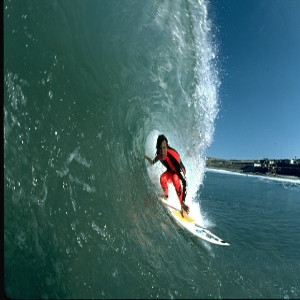

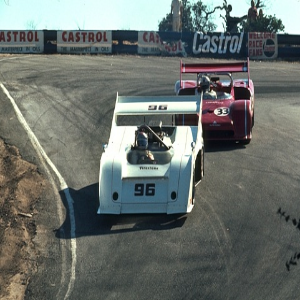

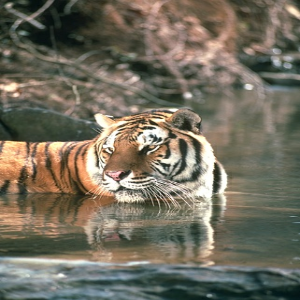

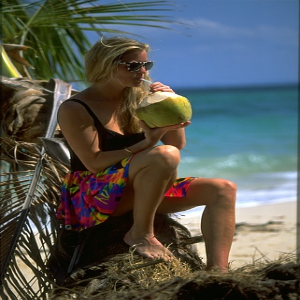

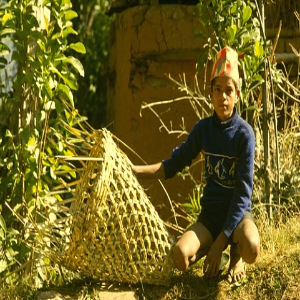

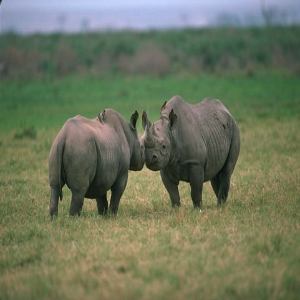

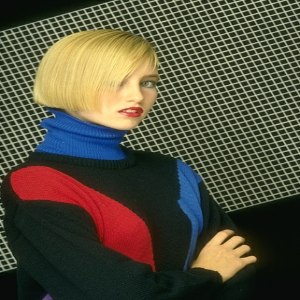

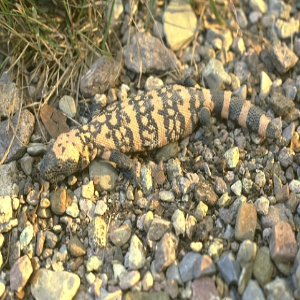

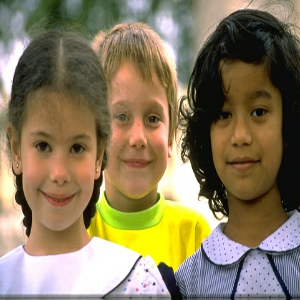

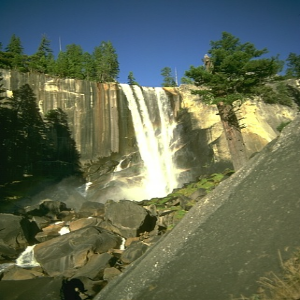

In [ ]:
# This is how input images to the model looks
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))  # array_to_img function displays numpy array as image
    # this will display 10 imgs as batch_size was set to 10 previously

# Image preprocessing
We need some cropping and resizing of input and output images to be fed to model before during training.

Here we convert RGB img to YUV space and retain only Y component followed by resizing image

In [ ]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)


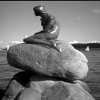

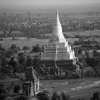

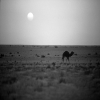

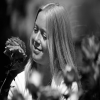

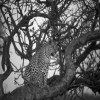

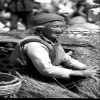

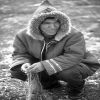

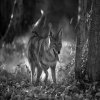

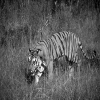

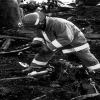

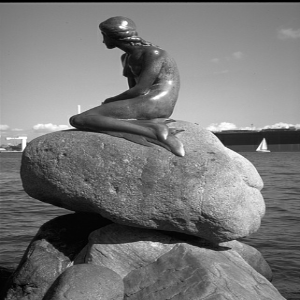

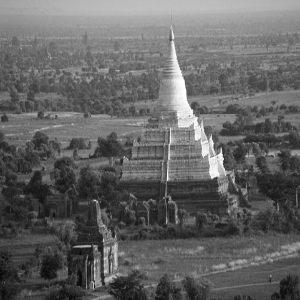

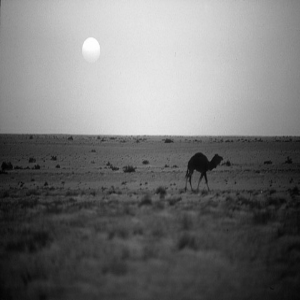

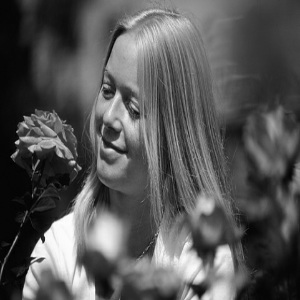

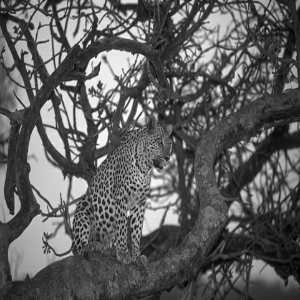

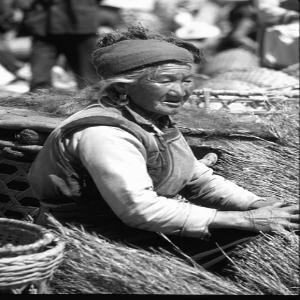

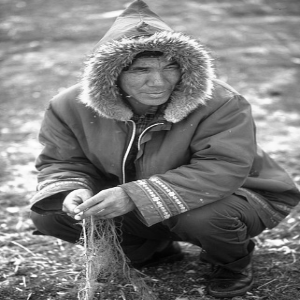

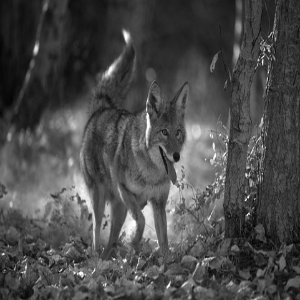

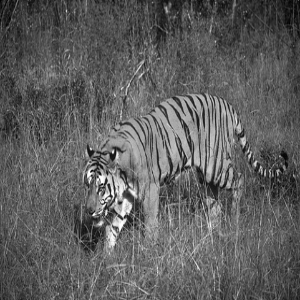

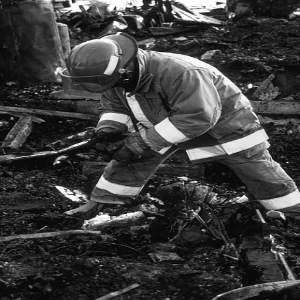

In [ ]:
# Visualising i/p and o/p images that are fed to model for training
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))    # i/p images to model
    for img in batch[1]:
        display(array_to_img(img))    #output images for model

# Building the Model

In [ ]:
channels = 1
inputs = keras.Input(shape=(None, None, channels))
x = layers.Conv2D(64, 5, padding='same', activation='tanh')(inputs)
x = layers.Conv2D(64, 3, padding='same', activation='tanh')(x)
x = layers.Conv2D(32, 3, padding='same', activation='tanh')(x)
x = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same', activation='tanh')(x)
outputs = tf.nn.depth_to_space(x, upscale_factor)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf_op_layer_DepthToSpace (Te [(None, None, None, 1)]   0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
__________________________________________________

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# some useful functions
def get_low_res_img(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display the PSNR - main metric we use to evaluate super-resolution performance.

**PSNR** : Peak Signal-to-Noise Ratio is a metric of how "closely" the super-resolved image reconstructed from its low-res value resembles the original high quality image.

In [ ]:
class ESPCNCallBack(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallBack, self).__init__()
        self.test_img = get_low_res_img(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

Epoch 1/100
Mean PSNR for epoch: 20.36


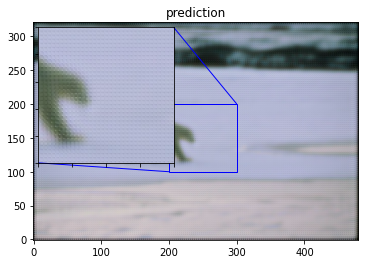

40/40 - 3s - loss: 0.0242 - val_loss: 0.0089
Epoch 2/100
Mean PSNR for epoch: 22.37
40/40 - 2s - loss: 0.0079 - val_loss: 0.0063
Epoch 3/100
Mean PSNR for epoch: 21.96
40/40 - 2s - loss: 0.0068 - val_loss: 0.0062
Epoch 4/100
Mean PSNR for epoch: 22.64
40/40 - 2s - loss: 0.0057 - val_loss: 0.0052
Epoch 5/100
Mean PSNR for epoch: 22.39
40/40 - 2s - loss: 0.0055 - val_loss: 0.0062
Epoch 6/100
Mean PSNR for epoch: 22.93
40/40 - 2s - loss: 0.0055 - val_loss: 0.0053
Epoch 7/100
Mean PSNR for epoch: 23.67
40/40 - 2s - loss: 0.0049 - val_loss: 0.0046
Epoch 8/100
Mean PSNR for epoch: 23.79
40/40 - 2s - loss: 0.0047 - val_loss: 0.0044
Epoch 9/100
Mean PSNR for epoch: 24.10
40/40 - 2s - loss: 0.0047 - val_loss: 0.0044
Epoch 10/100
Mean PSNR for epoch: 23.95
40/40 - 2s - loss: 0.0047 - val_loss: 0.0042
Epoch 11/100
Mean PSNR for epoch: 23.98
40/40 - 2s - loss: 0.0048 - val_loss: 0.0043
Epoch 12/100
Mean PSNR for epoch: 23.74
40/40 - 2s - loss: 0.0045 - val_loss: 0.0042
Epoch 13/100
Mean PSNR for e

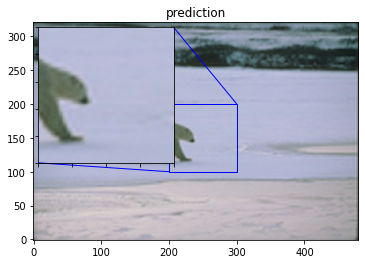

40/40 - 3s - loss: 0.0043 - val_loss: 0.0041
Epoch 22/100
Mean PSNR for epoch: 23.51
40/40 - 2s - loss: 0.0044 - val_loss: 0.0044
Epoch 23/100
Mean PSNR for epoch: 23.95
40/40 - 2s - loss: 0.0046 - val_loss: 0.0043
Epoch 24/100
Mean PSNR for epoch: 23.97
40/40 - 2s - loss: 0.0043 - val_loss: 0.0042
Epoch 25/100
Mean PSNR for epoch: 23.91
40/40 - 2s - loss: 0.0043 - val_loss: 0.0044
Epoch 26/100
Mean PSNR for epoch: 24.14
40/40 - 2s - loss: 0.0047 - val_loss: 0.0041
Epoch 27/100
Mean PSNR for epoch: 23.88
40/40 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 28/100
Mean PSNR for epoch: 23.72
40/40 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 29/100
Mean PSNR for epoch: 23.42
40/40 - 2s - loss: 0.0048 - val_loss: 0.0042
Epoch 30/100
Mean PSNR for epoch: 24.07
40/40 - 2s - loss: 0.0045 - val_loss: 0.0041
Epoch 31/100
Mean PSNR for epoch: 23.85
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 32/100
Mean PSNR for epoch: 24.11
40/40 - 2s - loss: 0.0044 - val_loss: 0.0040
Epoch 33/100
Mean PS

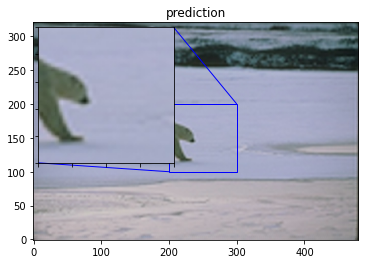

40/40 - 3s - loss: 0.0043 - val_loss: 0.0047
Epoch 42/100
Mean PSNR for epoch: 24.01
40/40 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 43/100
Mean PSNR for epoch: 23.85
40/40 - 2s - loss: 0.0043 - val_loss: 0.0041
Epoch 44/100
Mean PSNR for epoch: 24.00
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 45/100
Mean PSNR for epoch: 23.25
40/40 - 2s - loss: 0.0043 - val_loss: 0.0047
Epoch 46/100
Mean PSNR for epoch: 24.13
40/40 - 2s - loss: 0.0046 - val_loss: 0.0040
Epoch 47/100
Mean PSNR for epoch: 23.69
40/40 - 2s - loss: 0.0042 - val_loss: 0.0043
Epoch 48/100
Mean PSNR for epoch: 23.68
40/40 - 2s - loss: 0.0044 - val_loss: 0.0043
Epoch 49/100
Mean PSNR for epoch: 23.98
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 50/100
Mean PSNR for epoch: 24.02
40/40 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 51/100
Mean PSNR for epoch: 23.59
40/40 - 2s - loss: 0.0043 - val_loss: 0.0041
Epoch 52/100
Mean PSNR for epoch: 24.00
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 53/100
Mean PS

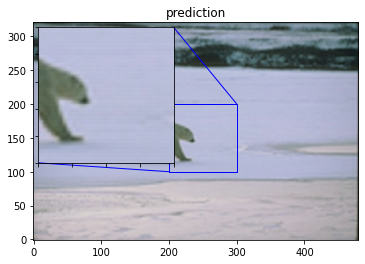

40/40 - 3s - loss: 0.0044 - val_loss: 0.0042
Epoch 62/100
Mean PSNR for epoch: 24.08
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 63/100
Mean PSNR for epoch: 23.47
40/40 - 2s - loss: 0.0043 - val_loss: 0.0046
Epoch 64/100
Mean PSNR for epoch: 24.23
40/40 - 2s - loss: 0.0044 - val_loss: 0.0039
Epoch 65/100
Mean PSNR for epoch: 23.90
40/40 - 2s - loss: 0.0042 - val_loss: 0.0043
Epoch 66/100
Mean PSNR for epoch: 23.87
40/40 - 2s - loss: 0.0043 - val_loss: 0.0043
Epoch 67/100
Mean PSNR for epoch: 23.84
40/40 - 2s - loss: 0.0044 - val_loss: 0.0042
Epoch 68/100
Mean PSNR for epoch: 24.09
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 69/100
Mean PSNR for epoch: 23.65
40/40 - 2s - loss: 0.0043 - val_loss: 0.0041
Epoch 70/100
Mean PSNR for epoch: 23.35
40/40 - 2s - loss: 0.0043 - val_loss: 0.0045
Epoch 71/100
Mean PSNR for epoch: 23.97
40/40 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 72/100
Mean PSNR for epoch: 23.70
40/40 - 2s - loss: 0.0045 - val_loss: 0.0041
Epoch 73/100
Mean PS

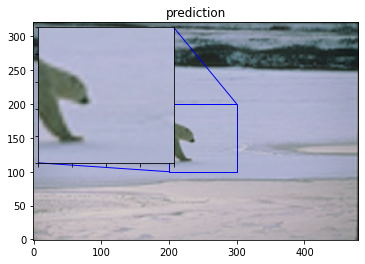

40/40 - 3s - loss: 0.0042 - val_loss: 0.0039
Epoch 82/100
Mean PSNR for epoch: 24.57
40/40 - 2s - loss: 0.0043 - val_loss: 0.0039
Epoch 83/100
Mean PSNR for epoch: 23.69
40/40 - 2s - loss: 0.0044 - val_loss: 0.0044
Epoch 84/100
Mean PSNR for epoch: 23.92
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 85/100
Mean PSNR for epoch: 24.17
40/40 - 2s - loss: 0.0042 - val_loss: 0.0040
Epoch 86/100
Mean PSNR for epoch: 23.83
40/40 - 2s - loss: 0.0042 - val_loss: 0.0042
Epoch 87/100
Mean PSNR for epoch: 24.34
40/40 - 2s - loss: 0.0042 - val_loss: 0.0039
Epoch 88/100
Mean PSNR for epoch: 23.55
40/40 - 2s - loss: 0.0042 - val_loss: 0.0043
Epoch 89/100
Mean PSNR for epoch: 23.97
40/40 - 2s - loss: 0.0043 - val_loss: 0.0039
Epoch 90/100
Mean PSNR for epoch: 24.41
40/40 - 2s - loss: 0.0042 - val_loss: 0.0039
Epoch 91/100
Mean PSNR for epoch: 24.45
40/40 - 2s - loss: 0.0042 - val_loss: 0.0040
Epoch 92/100
Mean PSNR for epoch: 24.06
40/40 - 2s - loss: 0.0042 - val_loss: 0.0039
Epoch 93/100
Mean PS

In [ ]:
epochs = 100
# we also need to save the model while training so as to make predictions later on
checkpoint_filepath = "/tmp/checkpoint"  # directory where model wts will be saved


model.compile(
    optimizer=keras.optimizers.Adam(lr = .001), loss=keras.losses.MeanSquaredError())

model.fit(
    train_ds, epochs=epochs, validation_data=valid_ds, verbose = 2, callbacks = [ESPCNCallBack(), keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_filepath,
        save_weights_only=True,
        monitor="loss",
        mode="min",
        save_best_only=True,   # we will only save the best model, best => min MSE loss 
    )]
)


In [ ]:
# Loading the "best" model that was achieved during training
model.load_weights(checkpoint_filepath)

# Save the entire model as a SavedModel, so that we can download it and dont need to retrain again and again
!mkdir -p saved_model
model.save('saved_model/my_model')

# # Reload a fresh Keras model from the saved model:
# new_model = tf.keras.models.load_model('saved_model/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


# Predictions :)

In [ ]:
# we also need to create a list of test images (with location) for inference model

test_img_paths = []
for file_name in os.listdir('/content/BSR/BSDS500/data/images/test/'):
  if file_name[-4:] == ".jpg":
    test_img_paths.append('/content/BSR/BSDS500/data/images/test/'+file_name)
    
test_img_paths.sort()    # 200 test images


PSNR of predict and high resolution is 23.276


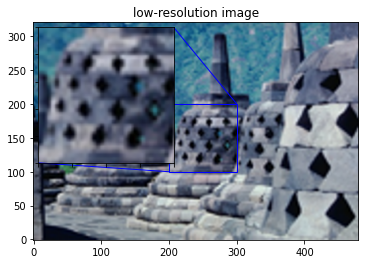

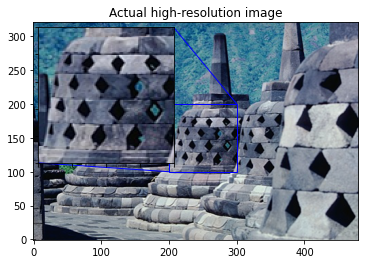

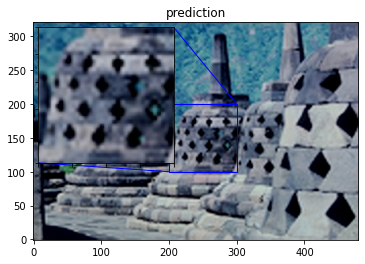

PSNR of predict and high resolution is 22.606


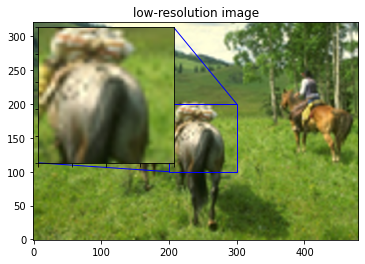

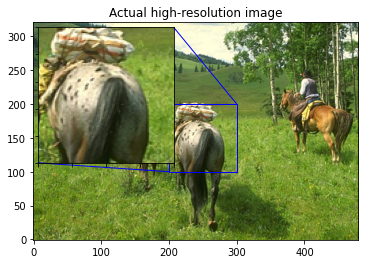

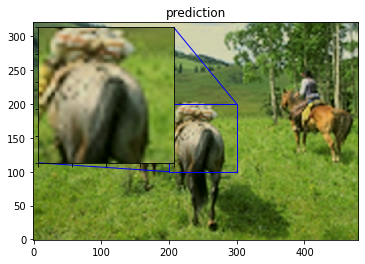

PSNR of predict and high resolution is 22.377


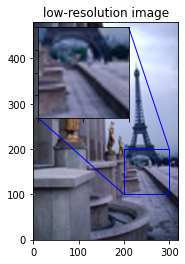

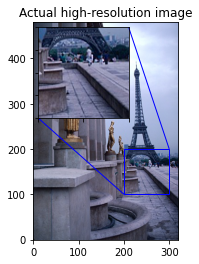

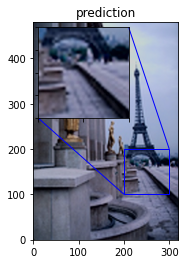

PSNR of predict and high resolution is 21.381


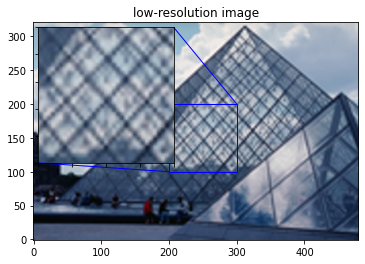

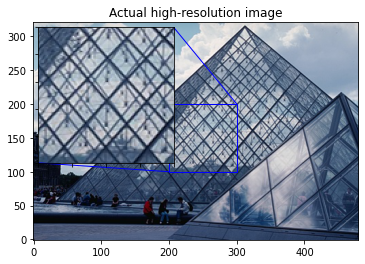

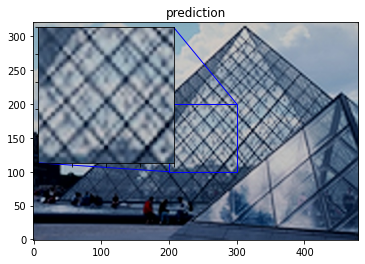

PSNR of predict and high resolution is 25.468


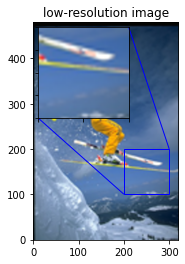

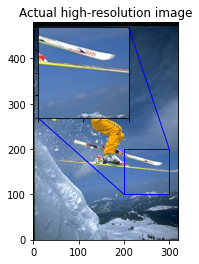

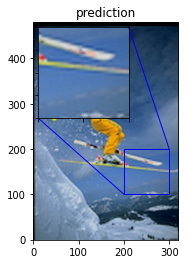

Avg. PSNR of reconstructions is 23.022


In [ ]:
total_test_psnr = 0.0
import random
i = random.randint(0,190)
for index, test_img_path in enumerate(test_img_paths[i:i+5]):  # we'll be running inference model on batch of 5 images
    img = load_img(test_img_path)
    lowres_input = get_low_res_img(img, upscale_factor)
    width = lowres_input.size[0] * upscale_factor
    height = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((width, height))
    lowres_img = lowres_input.resize((width, height))
    prediction = upscale_image(model, lowres_input) 
    test_psnr = tf.image.psnr(img_to_array(prediction), img_to_array(highres_img), max_val=255)

    total_test_psnr += test_psnr

    print("PSNR of predict and high resolution is %.3f" % test_psnr)
    plot_results(lowres_img, index, "low-resolution image")
    plot_results(highres_img, index, "Actual high-resolution image")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of reconstructions is %.3f" % (total_test_psnr / 5))

**Lets try a different activation function 'Relu' and rebuild the model as the previous model the prediction and low-res images are not appearing significantly different**

In [ ]:
channels = 1
inputs = keras.Input(shape=(None, None, channels))
x = layers.Conv2D(64, 5, padding='same', activation='relu')(inputs)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same', activation='relu')(x)
outputs = tf.nn.depth_to_space(x, upscale_factor)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf_op_layer_DepthToSpace_1 ( [(None, None, None, 1)]   0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
__________________________________________________

Epoch 1/200
Mean PSNR for epoch: 22.51


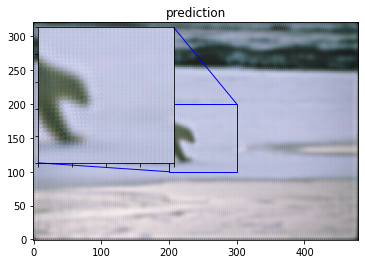

40/40 - 3s - loss: 0.0096 - val_loss: 0.0054
Epoch 2/200
Mean PSNR for epoch: 24.58
40/40 - 2s - loss: 0.0048 - val_loss: 0.0037
Epoch 3/200
Mean PSNR for epoch: 25.30
40/40 - 2s - loss: 0.0036 - val_loss: 0.0032
Epoch 4/200
Mean PSNR for epoch: 25.34
40/40 - 2s - loss: 0.0032 - val_loss: 0.0029
Epoch 5/200
Mean PSNR for epoch: 25.50
40/40 - 2s - loss: 0.0030 - val_loss: 0.0028
Epoch 6/200
Mean PSNR for epoch: 25.93
40/40 - 2s - loss: 0.0029 - val_loss: 0.0027
Epoch 7/200
Mean PSNR for epoch: 26.27
40/40 - 2s - loss: 0.0028 - val_loss: 0.0026
Epoch 8/200
Mean PSNR for epoch: 26.02
40/40 - 2s - loss: 0.0029 - val_loss: 0.0027
Epoch 9/200
Mean PSNR for epoch: 26.46
40/40 - 2s - loss: 0.0028 - val_loss: 0.0026
Epoch 10/200
Mean PSNR for epoch: 25.98
40/40 - 2s - loss: 0.0027 - val_loss: 0.0026
Epoch 11/200
Mean PSNR for epoch: 25.71
40/40 - 2s - loss: 0.0027 - val_loss: 0.0026
Epoch 12/200
Mean PSNR for epoch: 25.84
40/40 - 2s - loss: 0.0027 - val_loss: 0.0026
Epoch 13/200
Mean PSNR for e

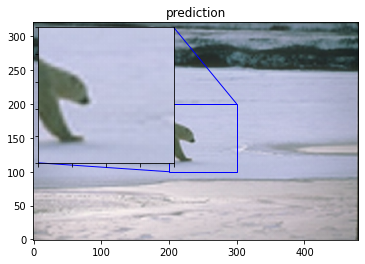

40/40 - 3s - loss: 0.0026 - val_loss: 0.0025
Epoch 22/200
Mean PSNR for epoch: 26.40
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 23/200
Mean PSNR for epoch: 26.26
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 24/200
Mean PSNR for epoch: 26.16
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 25/200
Mean PSNR for epoch: 25.56
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 26/200
Mean PSNR for epoch: 25.83
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 27/200
Mean PSNR for epoch: 25.71
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 28/200
Mean PSNR for epoch: 26.31
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 29/200
Mean PSNR for epoch: 25.88
40/40 - 2s - loss: 0.0026 - val_loss: 0.0026
Epoch 30/200
Mean PSNR for epoch: 25.86
40/40 - 2s - loss: 0.0027 - val_loss: 0.0025
Epoch 31/200
Mean PSNR for epoch: 26.01
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 32/200
Mean PSNR for epoch: 25.73
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Epoch 33/200
Mean PS

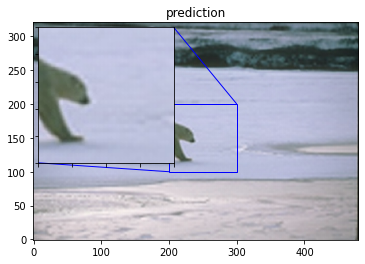

40/40 - 3s - loss: 0.0025 - val_loss: 0.0025
Epoch 42/200
Mean PSNR for epoch: 26.52
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Epoch 43/200
Mean PSNR for epoch: 26.35
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Epoch 44/200
Mean PSNR for epoch: 25.94
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 45/200
Mean PSNR for epoch: 25.98
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 46/200
Mean PSNR for epoch: 26.58
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 47/200
Mean PSNR for epoch: 26.53
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 48/200
Mean PSNR for epoch: 26.61
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Epoch 49/200
Mean PSNR for epoch: 26.48
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 50/200
Mean PSNR for epoch: 26.14
40/40 - 2s - loss: 0.0026 - val_loss: 0.0026
Epoch 51/200
Mean PSNR for epoch: 25.62
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 52/200
Mean PSNR for epoch: 26.20
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 53/200
Mean PS

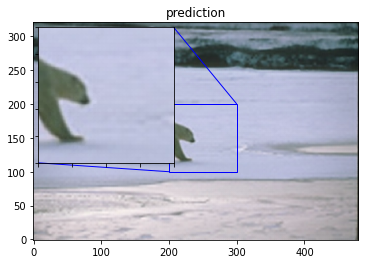

40/40 - 3s - loss: 0.0025 - val_loss: 0.0024
Epoch 62/200
Mean PSNR for epoch: 26.82
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 63/200
Mean PSNR for epoch: 26.30
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 64/200
Mean PSNR for epoch: 25.86
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 65/200
Mean PSNR for epoch: 26.55
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 66/200
Mean PSNR for epoch: 26.45
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 67/200
Mean PSNR for epoch: 26.29
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 68/200
Mean PSNR for epoch: 26.35
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 69/200
Mean PSNR for epoch: 26.36
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 70/200
Mean PSNR for epoch: 25.62
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Epoch 71/200
Mean PSNR for epoch: 26.87
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 72/200
Mean PSNR for epoch: 26.21
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 73/200
Mean PS

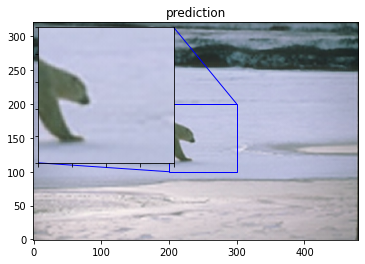

40/40 - 3s - loss: 0.0025 - val_loss: 0.0024
Epoch 82/200
Mean PSNR for epoch: 25.31
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 83/200
Mean PSNR for epoch: 26.03
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 84/200
Mean PSNR for epoch: 26.15
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 85/200
Mean PSNR for epoch: 26.61
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 86/200
Mean PSNR for epoch: 26.67
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 87/200
Mean PSNR for epoch: 26.35
40/40 - 2s - loss: 0.0026 - val_loss: 0.0024
Epoch 88/200
Mean PSNR for epoch: 25.21
40/40 - 2s - loss: 0.0033 - val_loss: 0.0027
Epoch 89/200
Mean PSNR for epoch: 25.52
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 90/200
Mean PSNR for epoch: 26.11
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 91/200
Mean PSNR for epoch: 26.54
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 92/200
Mean PSNR for epoch: 26.39
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 93/200
Mean PS

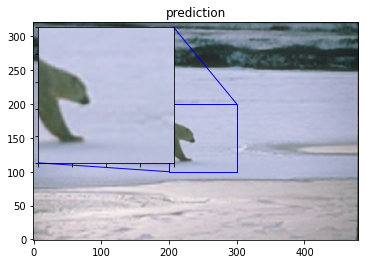

40/40 - 3s - loss: 0.0024 - val_loss: 0.0024
Epoch 102/200
Mean PSNR for epoch: 26.30
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 103/200
Mean PSNR for epoch: 26.40
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 104/200
Mean PSNR for epoch: 26.57
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 105/200
Mean PSNR for epoch: 25.89
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 106/200
Mean PSNR for epoch: 26.38
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 107/200
Mean PSNR for epoch: 26.50
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 108/200
Mean PSNR for epoch: 26.33
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 109/200
Mean PSNR for epoch: 26.00
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 110/200
Mean PSNR for epoch: 25.92
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 111/200
Mean PSNR for epoch: 25.66
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 112/200
Mean PSNR for epoch: 26.70
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 113

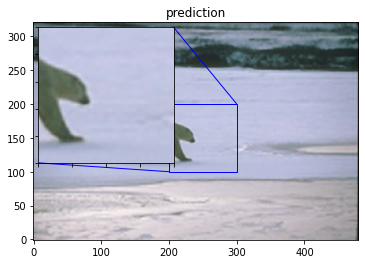

40/40 - 3s - loss: 0.0024 - val_loss: 0.0024
Epoch 122/200
Mean PSNR for epoch: 26.56
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 123/200
Mean PSNR for epoch: 26.48
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 124/200
Mean PSNR for epoch: 26.91
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 125/200
Mean PSNR for epoch: 26.33
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 126/200
Mean PSNR for epoch: 25.96
40/40 - 2s - loss: 0.0024 - val_loss: 0.0025
Epoch 127/200
Mean PSNR for epoch: 26.33
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 128/200
Mean PSNR for epoch: 26.31
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 129/200
Mean PSNR for epoch: 26.33
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 130/200
Mean PSNR for epoch: 25.84
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 131/200
Mean PSNR for epoch: 26.29
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 132/200
Mean PSNR for epoch: 25.96
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 133

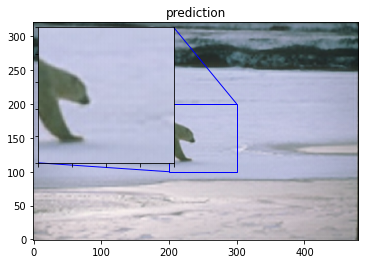

40/40 - 3s - loss: 0.0024 - val_loss: 0.0024
Epoch 142/200
Mean PSNR for epoch: 26.57
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 143/200
Mean PSNR for epoch: 26.25
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 144/200
Mean PSNR for epoch: 26.43
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 145/200
Mean PSNR for epoch: 25.88
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 146/200
Mean PSNR for epoch: 26.37
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 147/200
Mean PSNR for epoch: 26.16
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 148/200
Mean PSNR for epoch: 27.12
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 149/200
Mean PSNR for epoch: 26.51
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 150/200
Mean PSNR for epoch: 26.86
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 151/200
Mean PSNR for epoch: 26.21
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 152/200
Mean PSNR for epoch: 26.63
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 153

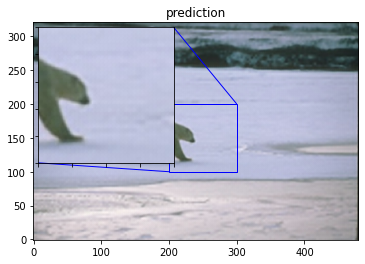

40/40 - 3s - loss: 0.0024 - val_loss: 0.0024
Epoch 162/200
Mean PSNR for epoch: 26.74
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 163/200
Mean PSNR for epoch: 25.32
40/40 - 2s - loss: 0.0025 - val_loss: 0.0033
Epoch 164/200
Mean PSNR for epoch: 26.07
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Epoch 165/200
Mean PSNR for epoch: 26.29
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 166/200
Mean PSNR for epoch: 26.47
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 167/200
Mean PSNR for epoch: 26.66
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 168/200
Mean PSNR for epoch: 26.93
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 169/200
Mean PSNR for epoch: 26.72
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 170/200
Mean PSNR for epoch: 25.91
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 171/200
Mean PSNR for epoch: 26.30
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 172/200
Mean PSNR for epoch: 25.48
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 173

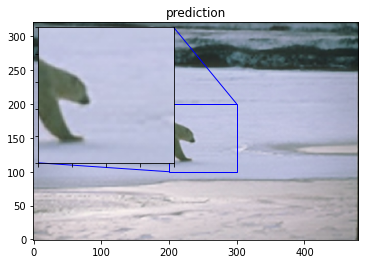

40/40 - 3s - loss: 0.0024 - val_loss: 0.0024
Epoch 182/200
Mean PSNR for epoch: 26.57
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 183/200
Mean PSNR for epoch: 26.16
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 184/200
Mean PSNR for epoch: 26.03
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 185/200
Mean PSNR for epoch: 26.32
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 186/200
Mean PSNR for epoch: 26.81
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 187/200
Mean PSNR for epoch: 25.62
40/40 - 2s - loss: 0.0030 - val_loss: 0.0025
Epoch 188/200
Mean PSNR for epoch: 26.40
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 189/200
Mean PSNR for epoch: 26.27
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 190/200
Mean PSNR for epoch: 26.49
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 191/200
Mean PSNR for epoch: 25.92
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 192/200
Mean PSNR for epoch: 25.87
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Epoch 193

In [ ]:
epochs = 200
! mkdir -p "/tmp/checkpoint2/"
! mkdir -p "/tmp/checkpoint2/model2"
# we also need to save the model while training so as to make predictions later on
checkpoint_filepath2 = "/tmp/checkpoint2/model2"  # directory where model wts will be saved


model2.compile(
    optimizer=keras.optimizers.Adam(lr = .001), loss=keras.losses.MeanSquaredError())

model2.fit(
    train_ds, epochs=epochs, validation_data=valid_ds, verbose = 2, callbacks = [ESPCNCallBack(), keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_filepath2,
        save_weights_only=True,
        monitor="loss",
        mode="min",
        save_best_only=True,   # we will only save the best model, best => min MSE loss 
    )]
)


In [ ]:
# Loading the "best" model that was achieved during training
model2.load_weights(checkpoint_filepath2)
# Save the entire model as a SavedModel, so that we can download it and dont need to retrain again and again
!mkdir -p saved_model2
model2.save('saved_model2/my_model')

INFO:tensorflow:Assets written to: saved_model2/my_model/assets


PSNR of predict and high resolution is 26.759


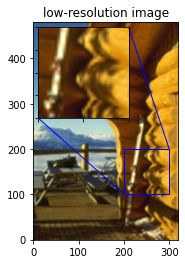

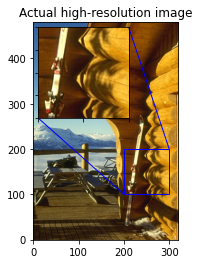

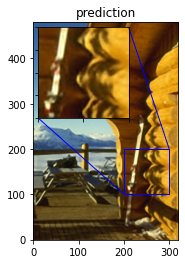

PSNR of predict and high resolution is 30.915


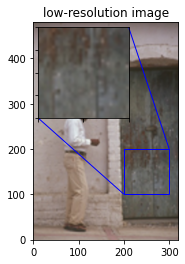

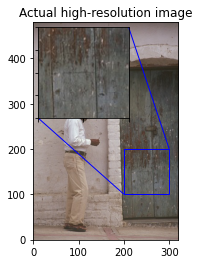

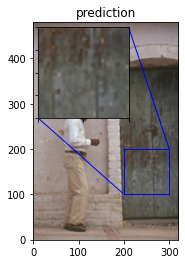

PSNR of predict and high resolution is 28.598


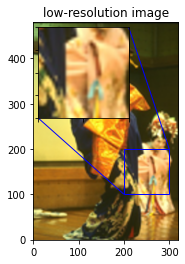

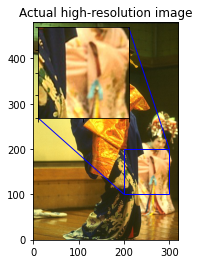

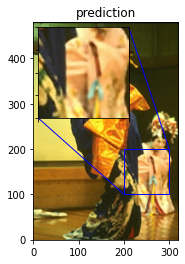

PSNR of predict and high resolution is 25.519


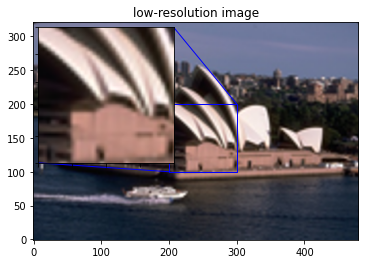

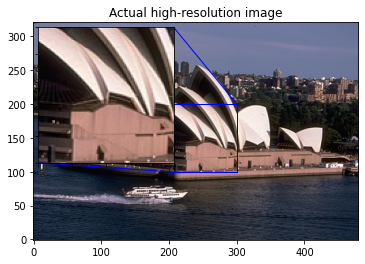

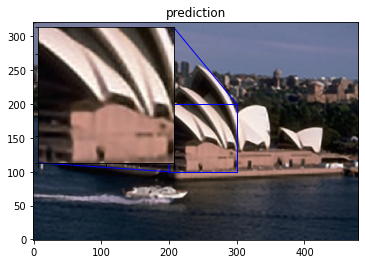

PSNR of predict and high resolution is 19.733


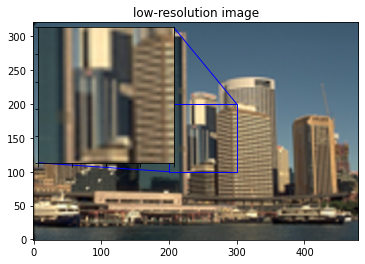

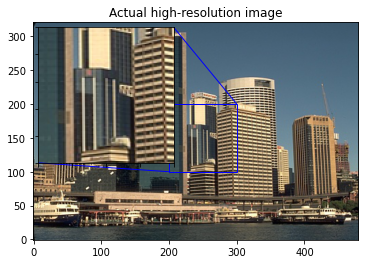

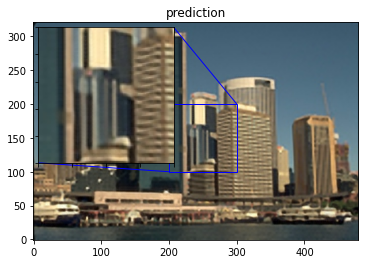

Avg. PSNR of reconstructions is 26.305


In [ ]:
total_test_psnr = 0.0
import random
i = random.randint(0,190)
for index, test_img_path in enumerate(test_img_paths[i:i+5]):  # we'll be running inference model on batch of 5 images
    img = load_img(test_img_path)
    lowres_input = get_low_res_img(img, upscale_factor)
    width = lowres_input.size[0] * upscale_factor
    height = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((width, height))
    lowres_img = lowres_input.resize((width, height))
    prediction = upscale_image(model2, lowres_input) 
    test_psnr = tf.image.psnr(img_to_array(prediction), img_to_array(highres_img), max_val=255)

    total_test_psnr += test_psnr

    print("PSNR of predict and high resolution is %.3f" % test_psnr)
    plot_results(lowres_img, index, "low-resolution image")
    plot_results(highres_img, index, "Actual high-resolution image")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of reconstructions is %.3f" % (total_test_psnr / 5))

***HENCE WE CAN CLEARLY SEE THAT WE IMPROVED UPON THE PREVIOUS MODEL BOTH THEORETICALLY (compare the avg PSNR values) and EVEN QUALITATIVELY (difference between predicted and Low-res image is more evident in the 2nd case)***